### 1. Importing libraries and data

In [3]:
!pip install nasdaq-data-link

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
import nasdaqdatalink

# Set your API key
nasdaqdatalink.ApiConfig.api_key = "ZA-UsraWHtc_qSx4PYB3"

# Fetch data for Apple stock (AAPL)
data = nasdaqdatalink.get_table('ZILLOW/DATA')

# Display the first few rows
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-07-31,486230.166077
1,ZSFH,99999,2024-06-30,485893.210056
2,ZSFH,99999,2024-05-31,484599.091201
3,ZSFH,99999,2024-04-30,481777.608669
4,ZSFH,99999,2024-03-31,480423.651093


In [6]:
data['date'].dtype

dtype('<M8[ns]')

In [7]:
data['year'] = data['date'].dt.year

In [8]:
data.head()

,indicator_id,region_id,date,value,year
None,,,,,
0,ZSFH,99999,2024-07-31,486230.166077,2024
1,ZSFH,99999,2024-06-30,485893.210056,2024
2,ZSFH,99999,2024-05-31,484599.091201,2024
3,ZSFH,99999,2024-04-30,481777.608669,2024
4,ZSFH,99999,2024-03-31,480423.651093,2024


In [9]:
data_sub = data.groupby('date')['value'].mean().reset_index()

In [10]:
data_sub

,date,value
0,1996-01-31,144105.857143
1,1996-02-29,144639.571429
2,1996-03-31,144922.000000
3,1996-04-30,145506.714286
4,1996-05-31,146361.571429
...,...,...
338,2024-03-31,460654.524462
339,2024-04-30,462714.281016
340,2024-05-31,464742.770947
341,2024-06-30,466148.830660


In [11]:
data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,value
datetime,
1996-01-31,144105.857143
1996-02-29,144639.571429
1996-03-31,144922.000000
1996-04-30,145506.714286
1996-05-31,146361.571429


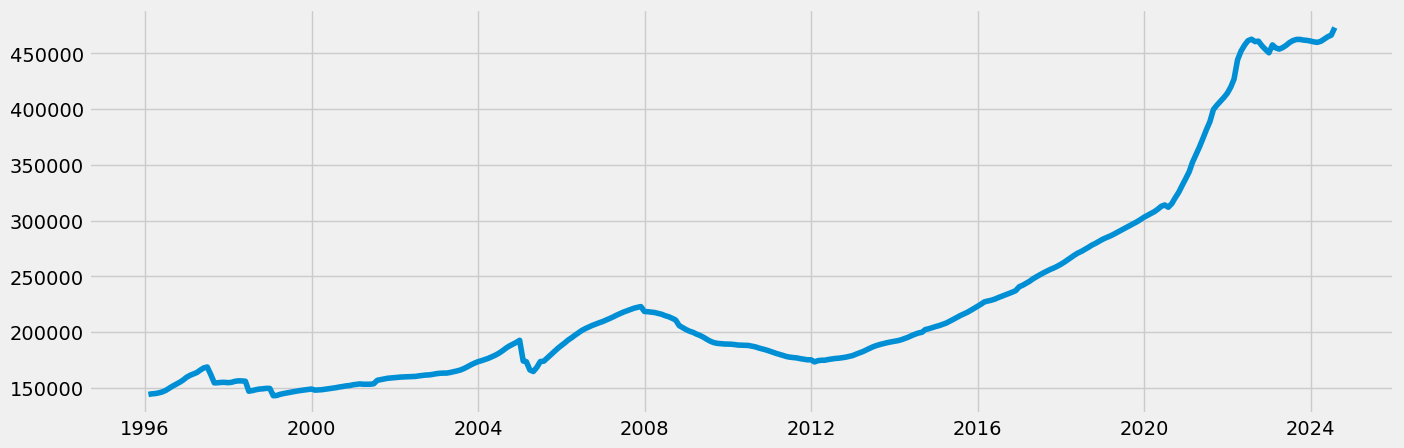

In [27]:
f = plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [29]:
f.savefig('test6.png')

### 2. Subsetting, wrangling, and cleaning time-series data

The original Zillow data included many different regions, spanning across many different years. I chose to make a subset of the data that is a daily average of home prices. This is shown in the above line graph.

In [15]:
data.isnull().sum() 

indicator_id    0
region_id       0
date            0
value           0
year            0
dtype: int64

In [16]:
#No missing data in original dataset

In [17]:
dups = data.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [19]:
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

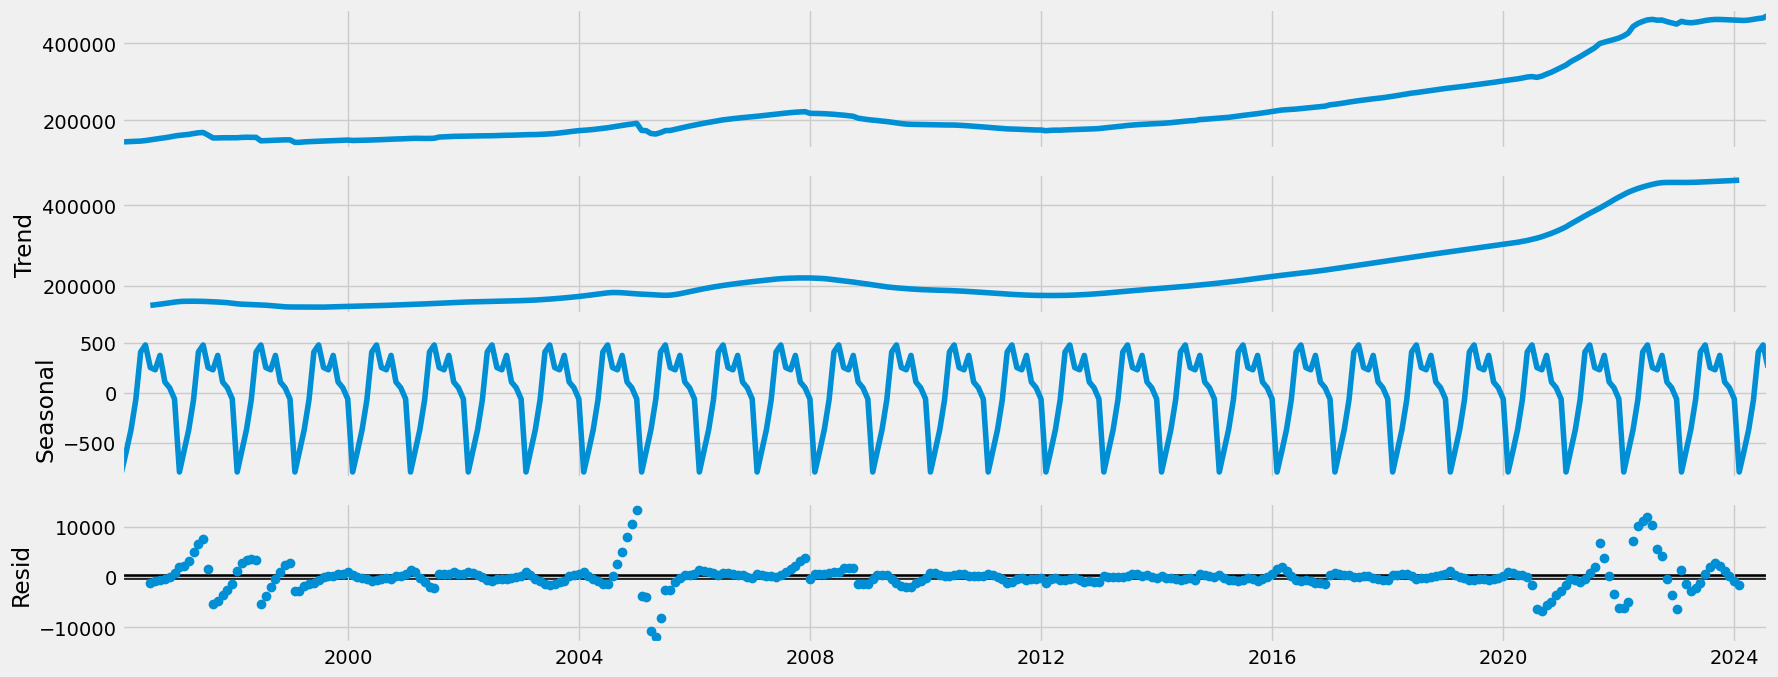

In [23]:
# Plot the separate components

f = decomposition.plot()
plt.show()

In [25]:
f.savefig('test5.png')

### 4. Testing for stationarity

In [362]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.061804
p-value                          0.994877
Number of Lags Used             10.000000
Number of Observations Used    332.000000
Critical Value (1%)             -3.450201
Critical Value (5%)             -2.870285
Critical Value (10%)            -2.571429
dtype: float64


### Test statistic of 1.062 is greater than our significance levels, indicating the data is not stationary

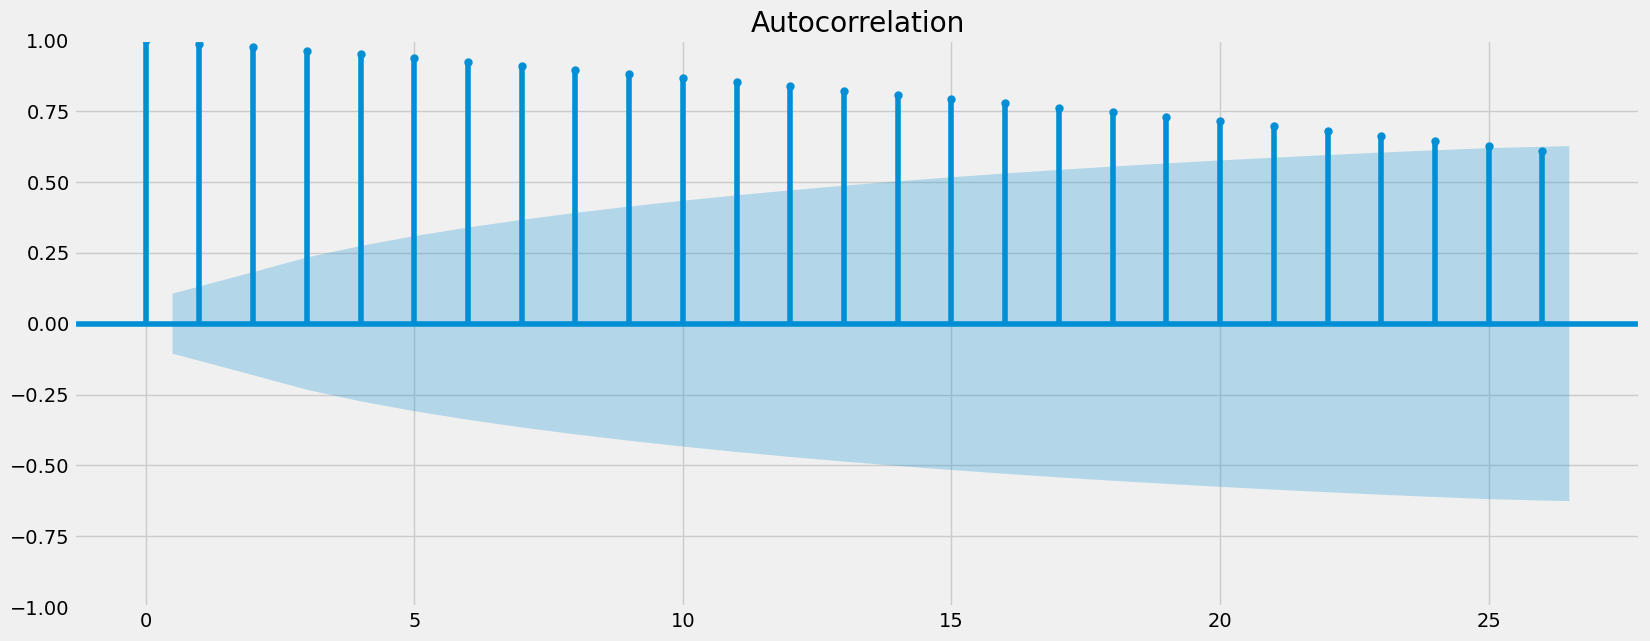

In [364]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Zillow Data

In [369]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [371]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [373]:
data_diff.head()

,value
datetime,
1996-02-29,533.714286
1996-03-31,282.428571
1996-04-30,584.714286
1996-05-31,854.857143
1996-06-30,1339.285714


In [375]:
data_diff.columns

Index(['value'], dtype='object')

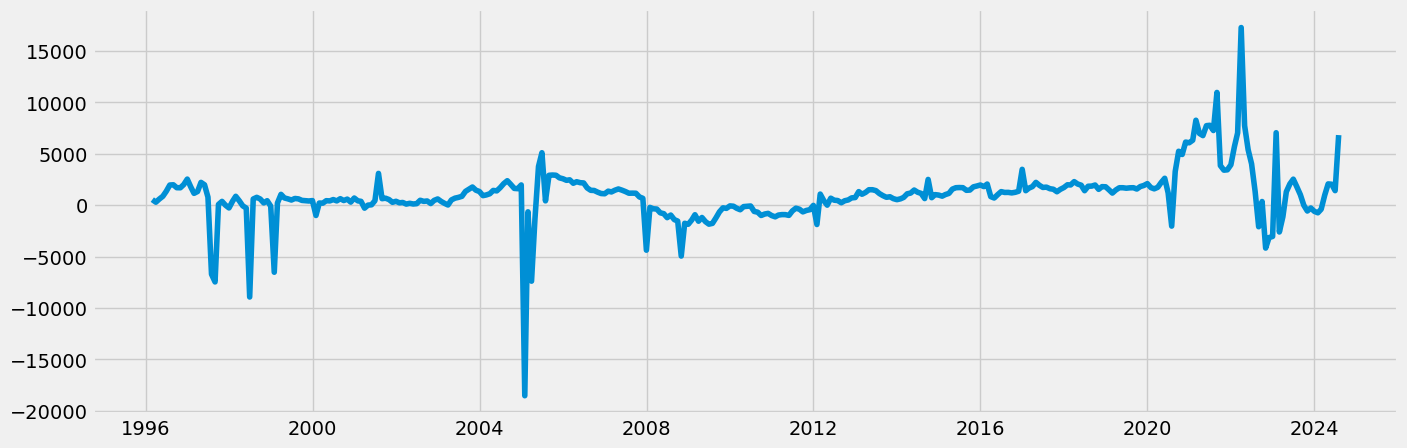

In [377]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [379]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.920768
p-value                          0.042986
Number of Lags Used              9.000000
Number of Observations Used    332.000000
Critical Value (1%)             -3.450201
Critical Value (5%)             -2.870285
Critical Value (10%)            -2.571429
dtype: float64


### Test statistic of -2.921 is less than our critical value (5%), indicating the data is now stationary.

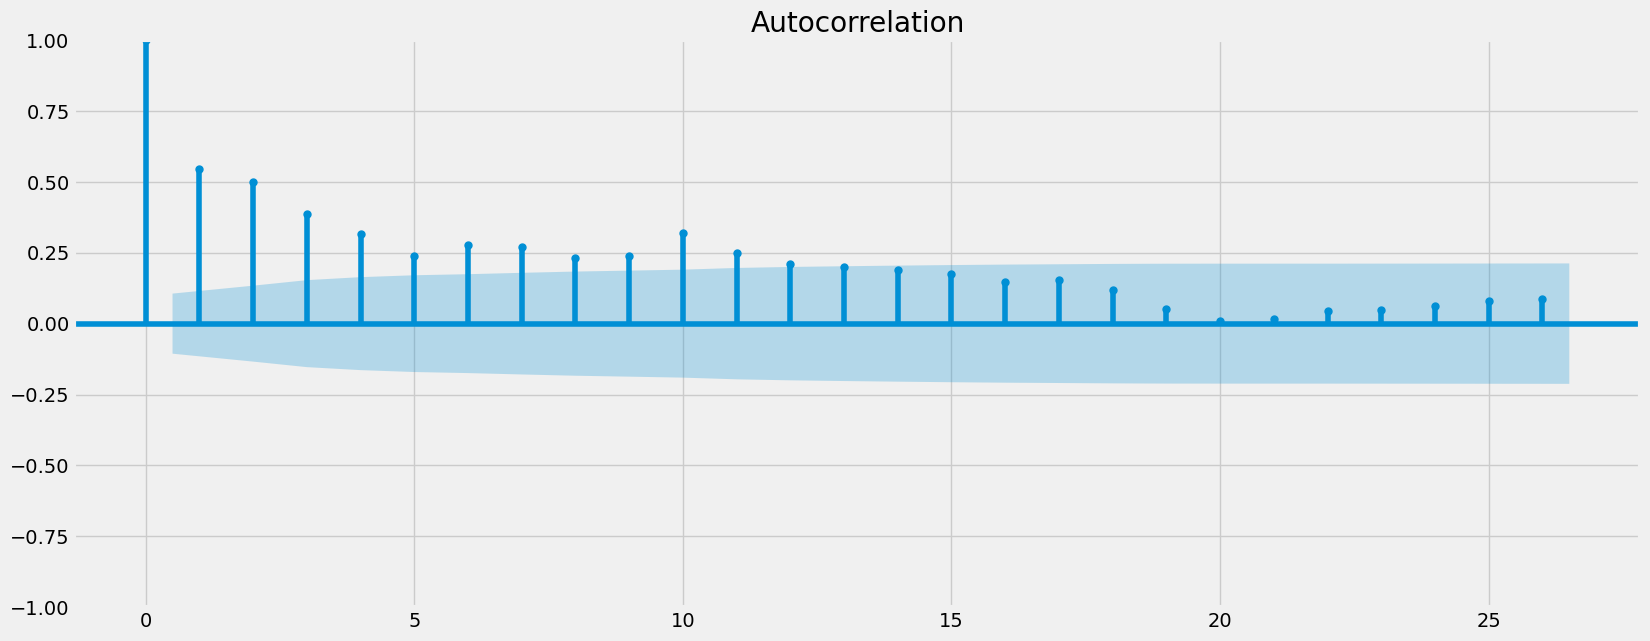

In [381]:
plot_acf(data_diff)
plt.show()